# Imports

In [1]:
import copy
import numpy as np
import itertools
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pixiedust

Pixiedust database opened successfully


# Defining functions

## Sigmoid

Sigmoid $\sigma(x) = \frac{1}{1+e^{-x}}$ and its derrivatives.

Sigmoid with parameter $t$
$$ \sigma_t(x) = \frac{1}{1+e^{-tx}}$$

In [2]:
T = 1

In [3]:
def sig(x):
    return 1 / (1 + np.exp(-T*x))

def sig1(x):
    return T * sig(x) * (1 - sig(x))

def sig2(x):
    return T * (sig1(x) - 2*sig(x)*sig1(x))

def sig3(x):
    return T * (sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x)))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

## RHS

The right side of the equation:  $\Delta\Psi(x,y) = f(x,y)$

In [4]:
def f(x, y, p):
    return 4/(1 + x**2 + y**2)**2

In [5]:
def psi_a(x, y):
    return np.log(1 + x**2 + y**2)

In [6]:
def psi_a_dx(x,y):
    return 2*x / (1 + x**2 + y**2)

In [7]:
def psi_a_dy(x,y):
    return 2*y / (1 + x**2 + y**2)

## Neural Network

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [8]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\frac{\partial^k N}{\partial x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [9]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\frac{\partial N}{\partial w_j} = x_j v \sigma '$$

In [10]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [11]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [12]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \frac{\partial}{\partial u} \frac{\partial^k}{\partial x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [13]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \frac{\partial}{\partial v} \frac{\partial^k}{\partial x_j^k} N = w_j^k \sigma^{(k)} $$

In [14]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Cost function

$$E[\vec{p}] = \sum_{i \in \hat{D}} \left\{ \frac{\partial^2 N}{\partial x^2} + \frac{\partial^2 N}{\partial y^2} - f(x,y) \right\}^2 
           +  \sum_{i \in \partial \hat{D}} (N - b_i)^2$$

In [15]:
BC=1

In [16]:
def error_term1(x, y, p):
    return dN_dxj_k(x,y,p,0,2)  +  dN_dxj_k(x,y,p,1,2)  -  f(x,y,p)

In [17]:
def cost(points, boundary_points, p):
    et1 = []
    et2 = []
    for x, y in points:
        err_sq = error_term1(x, y, p)**2
        et1.append(err_sq)
    
    for x, y in boundary_points:
        err_sq = (N(x,y,p)-psi_a(x,y))**2
        et2.append(err_sq)
        
    cost = sum(et1) + BC*sum(et2)
    
    return cost

In [18]:
def relative_err(p, dx_r=None, dx_th=None, all_points=None):
    if all_points == None:
        r = np.arange(dx_r/2, RADIUS+dx_r, dx_r)
        th = np.arange(dx_th/2, 2*np.pi+dx_th, dx_th)
        R, TH = np.meshgrid(r,th)

        x = np.ravel(2*R*(1-np.cos(TH))*np.cos(TH))
        y = np.ravel(2*R*(1-np.cos(TH))*np.sin(TH))

        all_points = list(zip(x,y))

#     dOmega = area / len(all_points)
    dOmega = 6 * np.pi * RADIUS**2 / len(all_points)

    trial1 = np.sum(dOmega*np.array([np.linalg.norm(N(x,y,p) - psi_a(x,y))**2
                                     for x, y in all_points]))

    trial2 = np.sum([dOmega*((dN_dxj_k(x,y,p,0,1)-psi_a_dx(x,y))**2 +
                             (dN_dxj_k(x,y,p,1,1)-psi_a_dy(x,y))**2)
                     for x, y in all_points])

    ana1 = np.sum(dOmega*np.array([np.linalg.norm(psi_a(x,y))**2
                                         for x, y in all_points]))
    ana2 = np.sum([dOmega*(psi_a_dx(x,y)**2 + psi_a_dy(x,y)**2)
                   for x, y in all_points])
    
    rel_err = (trial1 + trial2)**(1/2) / (ana1 + ana2)**(1/2)
    
    return rel_err

# Gradients

$$ \frac{\partial E[\vec{p}]}{\partial w_j} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial y^2} \right) \right\}  +  \sum_{i \in \partial \hat{D}} 2 (N - b_i) \frac{\partial N}{\partial w_j}$$

In [19]:
def dE_dwj(points, boundary_points, p, j):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_dwj_dN2_dxk2(x,y,p,j,0) + d_dwj_dN2_dxk2(x,y,p,j,1))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * (N(x,y,p)-psi_a(x,y)) * dN_dwj(x,y,p,j)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial u} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial y^2} \right) \right\} +  \sum_{i \in \partial \hat{D}} 2 (N - b_i) \frac{\partial N}{\partial u}$$

In [20]:
def dE_du(points, boundary_points, p):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_du_dkN(x,y,p,0,2) + d_du_dkN(x,y,p,1,2))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * (N(x,y,p)-psi_a(x,y)) * d_du_dkN(x,y,p,0,0)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial v} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial y^2} \right) \right\}  +  \sum_{i \in \partial \hat{D}} 2(N - b_i) \frac{\partial N}{\partial v}$$

In [21]:
def dE_dv(points, boundary_points, p):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_dv_dkN(x,y,p,0,2) + d_dv_dkN(x,y,p,1,2))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * (N(x,y,p)-psi_a(x,y)) * d_dv_dkN(x,y,p,0,0)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

# NN class

In [22]:
def initialize_p(hidden_nodes):
    w1 = np.random.randn(hidden_nodes)
    v = np.random.randn(hidden_nodes)
    w0 = []
    u = []

    for w1_sample in w1:
        t=1.6
        dth = 0.04
        r = np.array([RADIUS])
        a = np.arange(0, np.pi**t, dth)
        th = np.hstack([a**(1/t), -(a**(1/t))])
        R, TH = np.meshgrid(r, th)

        x_bound = np.ravel(2*R*(1-np.cos(TH))*np.cos(TH))
        y_bound = np.ravel(2*R*(1-np.cos(TH))*np.sin(TH))

        boundary_points = list(zip(x_bound, y_bound))
        
        x = np.random.choice(x_bound, 2, replace=False)
        y = np.random.choice(y_bound, 2, replace=False)
        
        slope = (y[1] - y[0]) / (x[1] - x[0])
        w0.append(-slope * w1_sample)
        u.append((slope*x[0] - y[0]) * w1_sample)

    p = np.array([np.array([np.array(w0), np.array(w1)]), 
                  np.array(u), np.array(v)])
    
    return p

In [23]:
def get_points(dx, dy, dth):
    t=1.6
    r = np.array([RADIUS])
    a = np.arange(0, np.pi**t, dth)
    th = np.hstack([a**(1/t), -(a**(1/t))])
    R, TH = np.meshgrid(r, th)

    x_bound = np.ravel(2*R*(1-np.cos(TH))*np.cos(TH))
    y_bound = np.ravel(2*R*(1-np.cos(TH))*np.sin(TH))

    boundary_points = list(zip(x_bound, y_bound))
    
    x_min=-4*RADIUS
    x_max=RADIUS/2
    y_min=-2*RADIUS*(1+np.cos(np.pi/3))*np.sin(np.pi/3)
    y_max=2*RADIUS*(1+np.cos(np.pi/3))*np.sin(np.pi/3)

    points_grid = np.mgrid[x_min:x_max+dx:dx, y_min:y_max+dy:dy].reshape(2,-1).T

    points = list(filter(
        lambda x: (np.sqrt(x[0]**2 + x[1]**2) / (2 * (1 - x[0]/np.sqrt(x[0]**2 + x[1]**2 + 1e-8)))) < RADIUS, 
        points_grid))
    
    return points, boundary_points

def get_points2(dx_r, dx_th, bx):
    r = np.arange(dx_r/2, RADIUS, dx_r)
    th = np.arange(dx_th/2, 2*np.pi+dx_th, dx_th)
    R, TH = np.meshgrid(r,th)

    r_bound = np.array([RADIUS])
    th_bound = np.arange(bx/2, 2*np.pi+bx, bx)
    R_bound, TH_bound = np.meshgrid(r_bound,th_bound)

    x = np.ravel(2*R*(1-np.cos(TH))*np.cos(TH))
    y = np.ravel(2*R*(1-np.cos(TH))*np.sin(TH))

    x_bound = np.ravel(2*R_bound*(1-np.cos(TH_bound))*np.cos(TH_bound))
    y_bound = np.ravel(2*R_bound*(1-np.cos(TH_bound))*np.sin(TH_bound))

    boundary_points = list(zip(x_bound, y_bound))
    points = [(a,b) for a, b in zip(x,y) if (a,b) not in boundary_points]

    return points, boundary_points

In [24]:
def get_mini_batches(points, boundary_points, batch_size):
    np.random.shuffle(points)
    np.random.shuffle(boundary_points)
    
    no_of_splits = np.ceil( (len(points) + len(boundary_points)) / batch_size)

    mini_batch_points = np.array_split(points, no_of_splits)
    mini_batch_boundary_points = np.array_split(boundary_points, no_of_splits)
    
    return mini_batch_points, mini_batch_boundary_points

In [25]:
class NNTrain:
    def __init__(self, dx=0.05, dy=0.05, bx=0.08, hidden_nodes=10, alpha=0.01,
                 batch_size=50, beta=0.9, update_interval=50,
                 if_rel_err=False, output_file='output/output.csv'):
        
        self.dx = dx
        self.dy = dy
        self.bx = bx
        self.output_file = output_file
        self.training_started = False
        self.hidden_nodes = hidden_nodes
        self.alpha = alpha
        self.batch_size = batch_size
        self.beta = beta
        self.update_interval = update_interval
        self.points, self.boundary_points = get_points(dx, dy, bx)
        self.cost_rate = []
        self.if_rel_err = if_rel_err
        if self.if_rel_err:
            self.rel_err = []
        self.p = initialize_p(hidden_nodes)
        self.m_t = np.array([np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes),
                             np.zeros(hidden_nodes)])
        
        
    def sgd_mt(self, w, g_t, theta_0):
        #gradient descent with momentum
        
        self.m_t[w] = self.beta * self.m_t[w] + (1-self.beta) * g_t
        theta_0 = theta_0 - (self.alpha*self.m_t[w])
            
        return theta_0
        

    def train(self, itr=1000):
        if self.training_started:
            mode='a'
        else:
            mode='w'
        self.training_started=True
        
        with open(self.output_file, mode) as file:
            if mode=='w':
                if self.if_rel_err:
                    file.write('Iteration,Cost,Cost Diff,Relative Error,Relative Error Diff\n')
                else:
                    file.write('Iteration,Cost,Cost Diff\n')
            start=len(self.cost_rate)-1
            if start<1:
                start+=1
                self.cost_rate.append(cost(self.points,self.boundary_points,self.p))
                if self.if_rel_err:
                    self.rel_err.append(relative_err(self.p, all_points=self.points+self.boundary_points))

            i = start
            while i < start+itr:
                mini_batch_points, mini_batch_boundary = get_mini_batches(self.points, self.boundary_points, self.batch_size)
                
                for mini_point, mini_boundary in zip(mini_batch_points, mini_batch_boundary):
                    mini_point = list(mini_point)
                    mini_boundary = list(mini_boundary)
                    
                    g_w0 = dE_dwj(mini_point, mini_boundary, self.p, 0)
                    g_w1 = dE_dwj(mini_point, mini_boundary, self.p, 1)
                    g_u = dE_du(mini_point, mini_boundary, self.p)
                    g_v = dE_dv(mini_point, mini_boundary, self.p)

                    self.p[0][0] = self.sgd_mt(0, g_w0, self.p[0][0])
                    self.p[0][1] = self.sgd_mt(1, g_w1, self.p[0][1])
                    self.p[1] = self.sgd_mt(2, g_u, self.p[1])
                    self.p[2] = self.sgd_mt(3, g_v, self.p[2])

                
                self.cost_rate.append(cost(self.points,self.boundary_points,self.p))
                cost_diff = self.cost_rate[i]-self.cost_rate[i+1]
                if self.if_rel_err:
                    self.rel_err.append(relative_err(self.p, all_points=self.points+self.boundary_points))
                    rel_diff = self.rel_err[i]-self.rel_err[i+1]

                if self.if_rel_err:
                    file.write('{},{:.8f},{:.8f},{:.8f},{:.8f}\n'.format(
                        i+1,self.cost_rate[i+1], cost_diff,
                        self.rel_err[i+1], rel_diff))
                else:
                    file.write('{},{:.8f},{:.8f}\n'.format(
                        i+1,self.cost_rate[i+1],
                        cost_diff))

                if i%self.update_interval==0:
                    file.flush()
                    
                i+=1
                
                
    def save_result(self, output_name=''):
        timestr = time.strftime("%Y%m%d-%H%M")
        np.savez('output/'+ timestr + '_' + output_name +'_nn_params.npz', self.p)
        np.savez('output/'+ timestr + '_' + output_name +'_cost_rate.npz', self.cost_rate)
        if self.if_rel_err:
            np.savez('output/'+ timestr + '_' + output_name +'_rel_err.npz', self.rel_err)

# Graphs

In [26]:
%matplotlib notebook
%matplotlib notebook

## Hidden Nodes

In [27]:
def plot_nodes(a, save_name=None, save=True, zlim=True):
    p = a.p
    hmax = a.p[0][0].shape[0]
    col = int(np.sqrt(hmax)) if int(np.sqrt(hmax)) < 10 else 10
    row = np.ceil(hmax / col)
    
    d_x=0.1

    fig = plt.figure(figsize=(col*3, row*3), dpi=100)
    for h in range(1,hmax+1):
        ax = fig.add_subplot(row,col,h, projection='3d')
        x = y = np.arange(0, 1+d_x, d_x)
        X, Y = np.meshgrid(x, y)

        zs = np.array([p[1][h-1]*sig(z(x,y,p))[h-1] for x,y in zip(np.ravel(X), np.ravel(Y))])
        Z = zs.reshape(X.shape)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if zlim:
            ax.set_zlim(0,1)

        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
        ax.title.set_text('HN: ' + str(h) + ', v=' + "{:.4E}".format(p[1][h-1]))
        time.sleep(0.2)

    if save==True:
        if save_name is None: 
            plt.savefig('t'+str(T)+'_h'+str(hmax)+'_n'+str(a.nx)+'.png')
        else:
            plt.savefig(save_name)
    else:
        plt.show()

## Error vs Iterations

In [28]:
def plot_iteration(arr, min_it=0, max_it=None):
    plt.figure()
    plt.plot(np.arange(len(arr[min_it:max_it])), np.array(arr[min_it:max_it]))
    plt.show()

## Solution Accuracy on the domain

In [29]:
def accuracy(p):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([psi_a(x,y)-psi_t(x,y,p) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
#     ax.set_zlabel('Accuracy')


    plt.show()

In [30]:
def plot_fun(fun, title=None, return_ax=False, xlim=None, ylim=None, zlim=None, **kwargs):
    dx_r=0.005
    dx_th=0.02

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    r = np.arange(dx_r/2, RADIUS+dx_r, dx_r)
    th = np.arange(dx_th/2, 2*np.pi+dx_th, dx_th)
    R, TH = np.meshgrid(r,th)

    X = 2*R*(1-np.cos(TH))*np.cos(TH)
    Y = 2*R*(1-np.cos(TH))*np.sin(TH)

    zs = np.array([fun(x,y,**kwargs) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.title.set_text(title)
    
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if zlim:
        ax.set_zlim(zlim[0], zlim[1])

    if return_ax:
        return ax
    else:
        plt.show()

In [31]:
def plot_partitions(p):
    t=1.6
    r = np.array([RADIUS])
    a = np.arange(0, np.pi**t, 0.01)
    th = np.hstack([a**(1/t), -(a**(1/t))])
    R, TH = np.meshgrid(r, th)

    x_bound = np.ravel(2*R*(1-np.cos(TH))*np.cos(TH))
    y_bound = np.ravel(2*R*(1-np.cos(TH))*np.sin(TH))
    
    plt.scatter(x_bound, y_bound, s=2)
    

    for HN in range(len(p[1])):
        x = np.linspace(-3,1,5000)
        y = -(p[1][HN] + p[0][0][HN]*x) / p[0][1][HN]

        plt.plot(x, y, label=HN)

#     plt.legend(loc='upper left')
    plt.xlim(-3,1)
    plt.ylim(-2.5,2.5)

# Training

Meta training

In [65]:
RADIUS=0.5
a = NNTrain(dx=0.035, dy=0.035, bx=0.02, hidden_nodes=4, alpha=1e-4, batch_size=50, update_interval=10, if_rel_err=True, output_file='out/out1.csv')

In [ ]:
BC=1
p=[]
p.append(copy.deepcopy(a.p))
a.train(110)

In [ ]:
thresh=1e-5
for i in range(10000):
    p.append(copy.deepcopy(a.p))
    if a.alpha < 1e-9 or BC > 10000:
        break
    if np.abs(np.mean([s-t for s, t in zip(a.cost_rate[-101:], a.cost_rate[-100:])]))  < thresh:
        BC=BC*10
        a.alpha=a.alpha/10
    a.train(100)

Etc

In [110]:
print('alpha:', a.alpha)
print('BC:', BC)
points, boundary_points = get_points(0.02, 0.02, 0.02)
all_points = points + boundary_points
print('relative error:', relative_err(a.p, all_points=all_points))

alpha: 1.0000000000000002e-07
BC: 1000
relative error: 0.09551861860928627


<IPython.core.display.Javascript object>


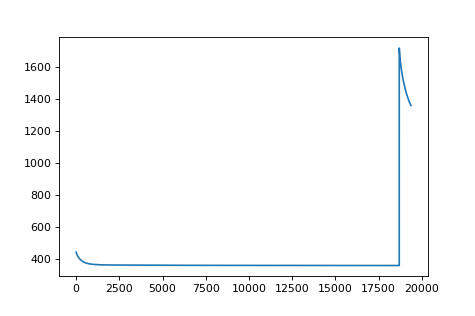

In [111]:
plot_iteration(a.cost_rate, min_it=50000)

<IPython.core.display.Javascript object>


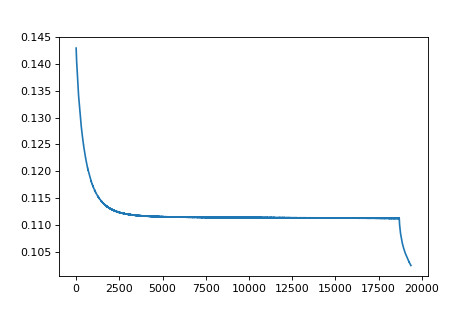

In [112]:
plot_iteration(a.rel_err, min_it=50000)

<IPython.core.display.Javascript object>


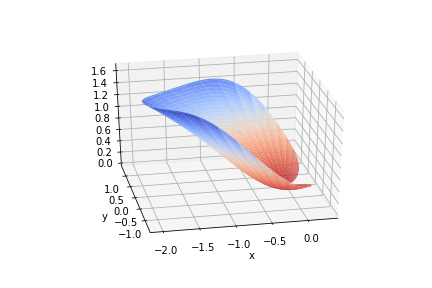

In [72]:
plot_fun(N, p=a.p)

<IPython.core.display.Javascript object>


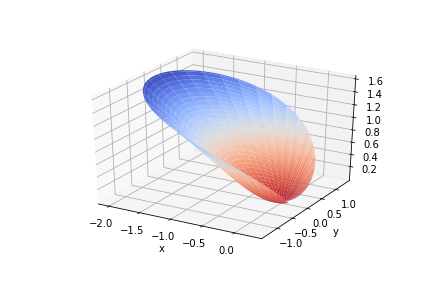

In [42]:
plot_fun(psi_a)

<IPython.core.display.Javascript object>


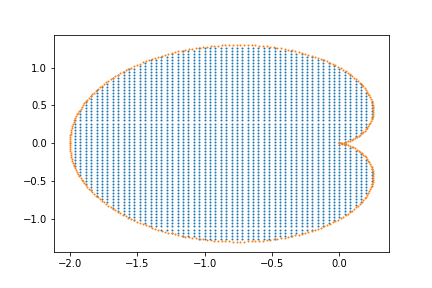

In [57]:
points, boundary_points = get_points(0.04, 0.04, 0.04)
plt.scatter(np.array(points).T[0], np.array(points).T[1], s=1)
plt.scatter(np.array(boundary_points).T[0], np.array(boundary_points).T[1], s=1)

In [35]:
len(points)

4191

In [36]:
len(boundary_points)

629

In [59]:
a.save_result('eq4_1_v4')

timestr = time.strftime("%Y%m%d-%H%M")
np.savez('output/'+ timestr + '_eq4_1_v4_momentum.npz', a.m_t)